In [65]:
import numpy as np
import os
from joblib import delayed, Parallel
import time
from analysis_funcs import rhg_lattice_scale, apply_error_channel, ParallelTqdm, find_connected_unit_cells
import networkx as nx
import matplotlib.pyplot as plt
from cluster_sim.app.grid import Grid
import pandas as pd


os.makedirs("./data", exist_ok=True)

shape = [30, 30, 200]
seed = 1

samples = 1

# Input vector for all jobs
jobs_input_vec = [(p, scale) for scale in range(4, 6) for p in np.linspace(0, 0.3, 30)]


In [66]:
def main(input_params):
    """
    Main function for parallel processing. Here, we:

    1. Create a grid of the given shape
    2. Apply the error channel to the grid
    3. Generate a RHG lattice
    4. Look at clusters of the RHG lattice
    5. Return the results

    Returns:
        - p: The input parameter for the simulation
        - percolates: The number of times percolation occurred (True: 1, False: 0)
        - times: The average time taken for the simulation
    """
    
    p, scale = input_params

    # Sanity check: check that this is equal to the move_list on the app
    # print(np.reshape(np.argwhere(removed_nodes == True), shape=-1))
    
    num_percolates = 0
    
    # store the outputs for 1 simulation
    data_out = []

    diff = 0

    for i in range(samples):
        percolate = 0
        start = time.time()
        G = Grid(shape)
        removed_nodes = np.zeros(shape[0] * shape[1] * shape[2], dtype=bool)

        G, D, removed_nodes = apply_error_channel(p, seed + i, shape, removed_nodes, G)
        # Generate an RHG lattice out of G
        G, D, removed_nodes, offsets = rhg_lattice_scale(G, D, removed_nodes, shape, scale_factor=scale)

        C = find_connected_unit_cells(G, shape, offsets, scale_factor=scale)

        if not C:
            data_out.append({
            "sample": i, 
            "p": p,
            "times": time.time() - start,
            "unit_cells": 0,
            "scale": scale,
            "percolates": 0,
            "diff" : 0
            })
            continue
        
        largest_cc = max(nx.connected_components(C), key=len)
        largest_cc = C.subgraph(largest_cc).copy()

        # Check if the largest cluster percolates
        low = np.array([np.inf, np.inf, np.inf])
        high = np.zeros(3)

        if not largest_cc:
            #print("No clusters")
            diff = 0

        else:
            for node in largest_cc.nodes:
                # Get the coordinates of the node
                low = np.minimum(low, np.array(node))
                high = np.maximum(high, np.array(node))
            diff = high[2] - low[2] 

            #print(f"high = {high}, low={low}, diff={diff}")
            if shape[2] - diff <= 2*(scale + 2):
                num_percolates += 1
                percolate = 1

        end = time.time()

        data_out.append({
        "sample": i, 
        "p": p,
        "times": end - start,
        "unit_cells": largest_cc.number_of_nodes(),
        "scale": scale,
        "percolates": percolate,
        "diff" : diff
        })

    print(f"p = {p}, percolates = {num_percolates}")

    return data_out


In [67]:
results = ParallelTqdm(n_jobs=-1)([delayed(main)(x) for x in jobs_input_vec])
results = [item for sublist in results for item in sublist]

df = pd.DataFrame(results)
df.to_csv("./data/test.csv", index=False, header=False, mode='a')


  2%|▏         | 1/60 [00:13<13:25, 13.65s/tasks]

p = 0.0, percolates = 1


  3%|▎         | 2/60 [00:14<06:00,  6.21s/tasks]

p = 0.010344827586206896, percolates = 1


  5%|▌         | 3/60 [00:16<04:04,  4.29s/tasks]

p = 0.020689655172413793, percolates = 1


  7%|▋         | 4/60 [00:18<03:08,  3.36s/tasks]

p = 0.03103448275862069, percolates = 1


  8%|▊         | 5/60 [00:19<02:24,  2.64s/tasks]

p = 0.041379310344827586, percolates = 1


 10%|█         | 6/60 [00:20<01:53,  2.09s/tasks]

p = 0.05172413793103448, percolates = 1


 12%|█▏        | 7/60 [00:22<01:46,  2.00s/tasks]

p = 0.06206896551724138, percolates = 1


 13%|█▎        | 8/60 [00:24<01:35,  1.84s/tasks]

p = 0.07241379310344828, percolates = 1


 15%|█▌        | 9/60 [00:37<04:34,  5.38s/tasks]

p = 0.08275862068965517, percolates = 1


 17%|█▋        | 10/60 [00:39<03:32,  4.24s/tasks]

p = 0.09310344827586206, percolates = 1


 18%|█▊        | 11/60 [00:42<03:09,  3.87s/tasks]

p = 0.10344827586206896, percolates = 1
p = 0.11379310344827587, percolates = 1


 22%|██▏       | 13/60 [00:48<02:43,  3.47s/tasks]

p = 0.12413793103448276, percolates = 1


 23%|██▎       | 14/60 [00:51<02:28,  3.23s/tasks]

p = 0.13448275862068965, percolates = 1


 25%|██▌       | 15/60 [00:53<02:08,  2.86s/tasks]

p = 0.14482758620689656, percolates = 1


 27%|██▋       | 16/60 [00:56<02:02,  2.79s/tasks]

p = 0.15517241379310345, percolates = 1


 28%|██▊       | 17/60 [01:10<04:34,  6.39s/tasks]

p = 0.16551724137931034, percolates = 1


 30%|███       | 18/60 [01:14<03:51,  5.52s/tasks]

p = 0.17586206896551723, percolates = 1


 32%|███▏      | 19/60 [01:19<03:44,  5.47s/tasks]

p = 0.18620689655172412, percolates = 0


 33%|███▎      | 20/60 [01:24<03:37,  5.43s/tasks]

p = 0.19655172413793104, percolates = 0


 35%|███▌      | 21/60 [01:27<03:02,  4.68s/tasks]

p = 0.20689655172413793, percolates = 0


 37%|███▋      | 22/60 [01:32<02:51,  4.51s/tasks]

p = 0.21724137931034482, percolates = 0


 38%|███▊      | 23/60 [01:35<02:34,  4.17s/tasks]

p = 0.22758620689655173, percolates = 0


 40%|████      | 24/60 [01:39<02:28,  4.13s/tasks]

p = 0.23793103448275862, percolates = 0


 42%|████▏     | 25/60 [01:45<02:46,  4.75s/tasks]

p = 0.0, percolates = 1


 43%|████▎     | 26/60 [01:50<02:45,  4.87s/tasks]

p = 0.010344827586206896, percolates = 1


 45%|████▌     | 27/60 [01:56<02:45,  5.01s/tasks]

p = 0.2482758620689655, percolates = 0


 47%|████▋     | 28/60 [02:00<02:32,  4.75s/tasks]

p = 0.020689655172413793, percolates = 1


 48%|████▊     | 29/60 [02:00<01:48,  3.51s/tasks]

p = 0.25862068965517243, percolates = 0


 50%|█████     | 30/60 [02:07<02:10,  4.34s/tasks]

p = 0.2689655172413793, percolates = 0


 52%|█████▏    | 31/60 [02:08<01:40,  3.45s/tasks]

p = 0.03103448275862069, percolates = 1


 53%|█████▎    | 32/60 [02:14<02:00,  4.30s/tasks]

p = 0.2793103448275862, percolates = 0


 55%|█████▌    | 33/60 [02:17<01:41,  3.77s/tasks]

p = 0.041379310344827586, percolates = 1


 57%|█████▋    | 34/60 [02:17<01:13,  2.82s/tasks]

p = 0.2896551724137931, percolates = 0


 58%|█████▊    | 35/60 [02:24<01:36,  3.87s/tasks]

p = 0.3, percolates = 0


 60%|██████    | 36/60 [02:25<01:13,  3.06s/tasks]

p = 0.05172413793103448, percolates = 1


 62%|██████▏   | 37/60 [02:28<01:10,  3.04s/tasks]

p = 0.06206896551724138, percolates = 1


 63%|██████▎   | 38/60 [02:35<01:35,  4.35s/tasks]

p = 0.07241379310344828, percolates = 1


 65%|██████▌   | 39/60 [02:39<01:24,  4.02s/tasks]

p = 0.08275862068965517, percolates = 1


 67%|██████▋   | 40/60 [02:47<01:47,  5.39s/tasks]

p = 0.09310344827586206, percolates = 1


 68%|██████▊   | 41/60 [02:52<01:41,  5.35s/tasks]

p = 0.10344827586206896, percolates = 1


 70%|███████   | 42/60 [02:55<01:20,  4.49s/tasks]

p = 0.11379310344827587, percolates = 1


 72%|███████▏  | 43/60 [03:03<01:36,  5.70s/tasks]

p = 0.12413793103448276, percolates = 1


 73%|███████▎  | 44/60 [03:07<01:21,  5.08s/tasks]

p = 0.13448275862068965, percolates = 1


 75%|███████▌  | 45/60 [03:13<01:20,  5.34s/tasks]

p = 0.14482758620689656, percolates = 1


 77%|███████▋  | 46/60 [03:22<01:30,  6.45s/tasks]

p = 0.15517241379310345, percolates = 1


 78%|███████▊  | 47/60 [03:27<01:19,  6.13s/tasks]

p = 0.16551724137931034, percolates = 1


 80%|████████  | 48/60 [03:38<01:30,  7.55s/tasks]

p = 0.17586206896551723, percolates = 1


 82%|████████▏ | 49/60 [03:46<01:24,  7.68s/tasks]

p = 0.18620689655172412, percolates = 1


 83%|████████▎ | 50/60 [03:51<01:06,  6.68s/tasks]

p = 0.19655172413793104, percolates = 1


 85%|████████▌ | 51/60 [04:02<01:13,  8.16s/tasks]

p = 0.20689655172413793, percolates = 1


 87%|████████▋ | 52/60 [04:09<01:01,  7.71s/tasks]

p = 0.21724137931034482, percolates = 0


 88%|████████▊ | 53/60 [04:17<00:53,  7.71s/tasks]

p = 0.22758620689655173, percolates = 0


 90%|█████████ | 54/60 [04:29<00:54,  9.06s/tasks]

p = 0.23793103448275862, percolates = 0


 92%|█████████▏| 55/60 [04:35<00:40,  8.14s/tasks]

p = 0.2482758620689655, percolates = 0


 93%|█████████▎| 56/60 [04:46<00:35,  8.94s/tasks]

p = 0.25862068965517243, percolates = 0


 95%|█████████▌| 57/60 [04:53<00:25,  8.42s/tasks]

p = 0.2689655172413793, percolates = 0


 97%|█████████▋| 58/60 [04:59<00:15,  7.61s/tasks]

p = 0.2793103448275862, percolates = 0


 98%|█████████▊| 59/60 [05:10<00:08,  8.76s/tasks]

p = 0.2896551724137931, percolates = 0


100%|██████████| 60/60 [05:17<00:00,  5.29s/tasks]

p = 0.3, percolates = 0


In [69]:
# Plotting for connected_unit cells

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

df = pd.read_csv("./data/test.csv")

df[df["scale"]  == 3]

,sample,p,times,unit_cells,scale,percolates,diff
60,0,0.000000,24.844251,2401,3,1,192.0
61,0,0.010345,18.893583,1764,3,1,192.0
62,0,0.020690,18.805316,1756,3,1,192.0
63,0,0.031034,19.207125,1748,3,1,192.0
64,0,0.041379,20.199940,1728,3,1,192.0
65,0,0.051724,19.835087,1695,3,1,192.0
66,0,0.062069,21.199470,1675,3,1,192.0
67,0,0.072414,21.024895,1566,3,1,192.0
68,0,0.082759,21.421708,1522,3,1,192.0
69,0,0.093103,21.636928,1392,3,1,192.0


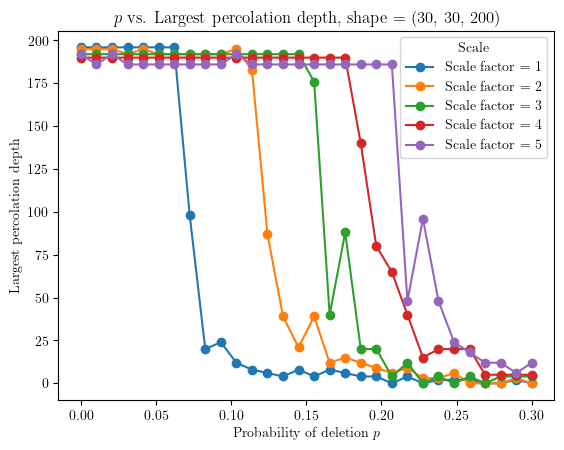

In [71]:
plt.rcParams.update({
    "text.usetex": True,
    'font.family': 'serif',
    'font.serif': ['Computer Modern']    
    })

#df['unit_cells_ratio'] = df['unit_cells']/df['unit_cells'].max()

#plt.figure(figsize=(10, 6))
for scale in df['scale'].unique():
    subset = df[df['scale'] == scale]
    plt.plot(subset['p'], subset['diff'], marker='o', label=f'Scale factor = {scale}')


plt.title("$p$ vs. Largest percolation depth, shape = (30, 30, 200)")
plt.xlabel("Probability of deletion $p$")
plt.ylabel("Largest percolation depth")
plt.legend(title="Scale")
#plt.savefig("data/connected_cells.pdf", dpi=300, bbox_inches='tight')
plt.show()